# Recommendation Systems
## Assignment 1: Matrix Factorization & Evaluation

**By:**  
Group 99

<br><br>

**The goal of this assignment is to:**
- Understand the details of matrix factorization algorithm
- Practice recommender system training and evaluation.

**Instructions:**
- Students will form teams of two people each, and submit a single homework for each team.
- The same score for the homework will be given to each member of the team.
- Your solution in the form of an Jupyter notebook file (with extension ipynb).
- Images/Graphs/Tables should be submitted inside the notebook.
- The notebook should be runnable and properly documented. 
- Please answer all the questions and include all your code.
- Please use English language only.

**Submission:**
- Submission of the homework will be done via Moodle by uploading a Jupyter notbook.
- The homework needs to be entirely in English.
- The deadline for submission is on Moodle.

**Requirements:**  
- Python 3.6+ should be used.  
- You should implement the matrix factorization algorithm by yourself using only basic Python libraries (such as numpy).



<br><br><br><br>

**Grading:**
- Q1 - 0 points - Data exploration
- Q2 - 25 points - Evaluation metrics
- Q3 - 50 points - Models implementation and evaluation
  -  A. Popularity basline model: 10 points
  -  B. Explicit Matrix Factorization: 25 points
  -  C. Train & HyperParams Search: 5 points 
  -  D. Bias only model: 5 points
  -  E. Discussion: 5 points
- Q4 - 25 points - Similarity & Explainability 

`Total: 100`

**Prerequisites**

In [ ]:
!pip install --quiet zipfile36

**Imports**

In [ ]:
# general
import time
import random
import zipfile
import requests
import warnings

# ml
import numpy as np
import scipy as sp
import pandas as pd

# visual
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

# metrics - do not use these metrics, but you can use them to check your work
from sklearn.metrics import mean_squared_error,ndcg_score 

# notebook
from IPython.display import FileLink, display

**Hide Warnings**

In [ ]:
warnings.filterwarnings('ignore')

**Disable Autoscrolling**

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

**Set Random Seed**

In [ ]:
random.seed(123)

# Question 1:

## Data exploration 

Download the MovieLens 100K rating dataset.   
Calculate the dataset sparsity, distribution of number of ratings as well as the average rating value per user\item.  
Include additional exploration you find relevant to questions 2 and 3.  
Discuss your insights and possible challenges related to the prediction task described in question 2.  

In [ ]:
url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
zip_name = 'ml-100k.zip'
data_dir = 'ml-100k/'

r = requests.get(url, allow_redirects=True)
open(zip_name, 'wb').write(r.content)

with zipfile.ZipFile(zip_name,"r") as zip_ref:
    zip_ref.extractall()

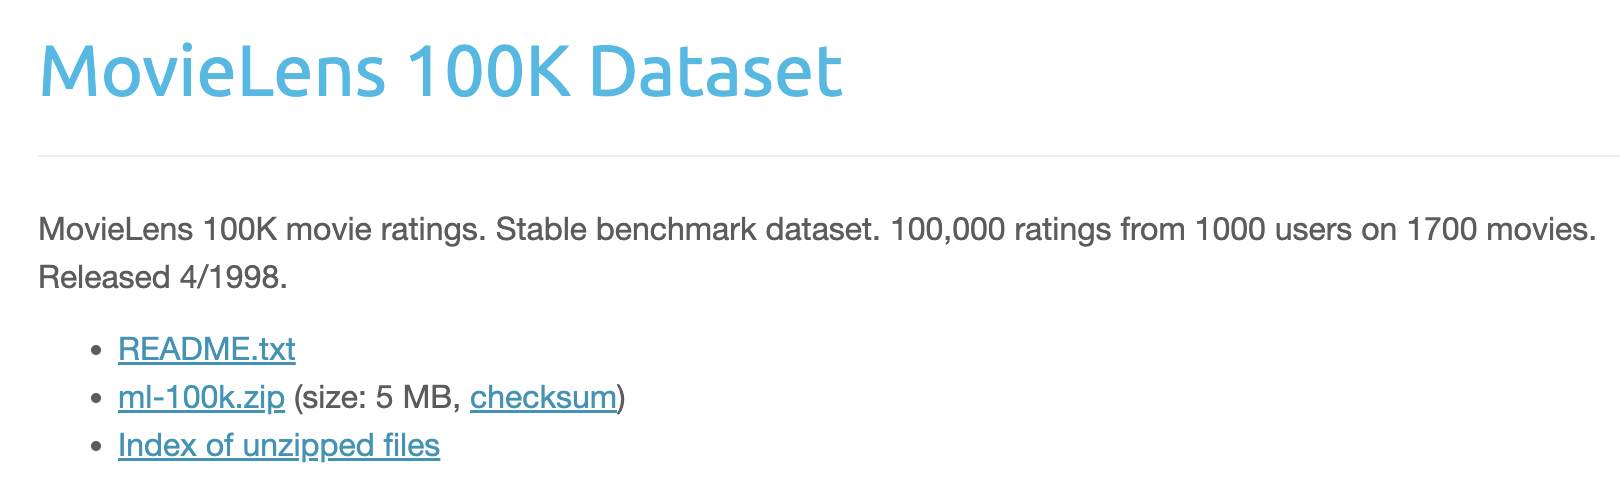

**Columns Names**

In [ ]:
cols_data = ['user_id','item_id','rating','timestamp']
cols_user = ['user_id','age','gender','occupation','zip code']
cols_item = ['movie id','movie_title','release_date','video_release_date','IMDb_URL','unknown','Action','Adventure','Animation',
             'Childrens','Comedy','Crime','Documentary','Drama','Fantasy','Film_Noir','Horror','Musical','Mystery','Romance',
             'Sci_Fi','Thriller','War','Western']

**Read users data file**

In [ ]:
df_users = pd.read_csv(data_dir + 'u.user',delimiter='|', header=None,names=cols_user)
df_users.shape

(943, 5)

**Read items(movies) data file**

In [ ]:
df_items = pd.read_csv(data_dir + 'u.item',delimiter='|', header=None,names=cols_item,encoding="ISO-8859-1")
df_items.shape

(1682, 24)

**Read rating data file**

In [ ]:
df_ratings = pd.read_csv(data_dir + 'u.data',delimiter='\t', header=None,names=cols_data)
df_ratings.shape

(100000, 4)

Making sure shapes are mathing the info data file

In [ ]:
open(data_dir + 'u.info').readlines()

['943 users\n', '1682 items\n', '100000 ratings\n']

**Matrix:**

In [ ]:
ratings = df_ratings.pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
ratings.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<br><br><br><br>

**Explore ratings data:**

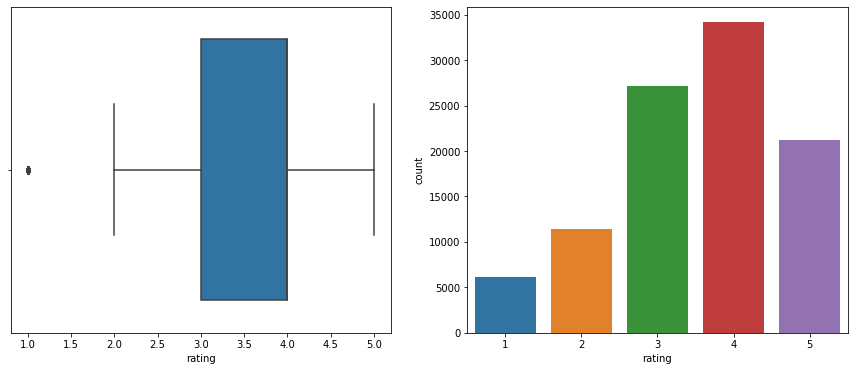

In [ ]:
f, axes = plt.subplots(1, 2,figsize=(15,6))
sns.boxplot(df_ratings.rating,ax=axes[0])
sns.countplot(df_ratings.rating,ax=axes[1])
plt.show()

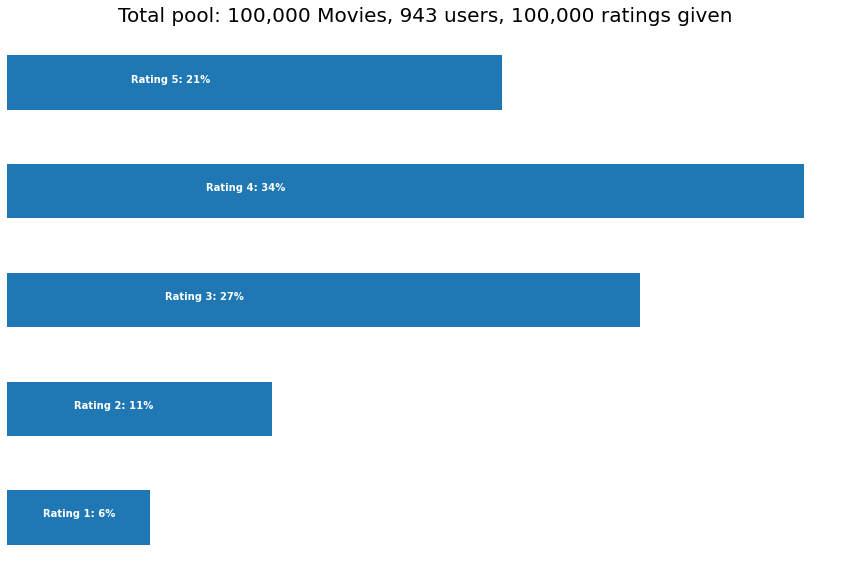

In [ ]:
p = df_ratings.groupby('rating')['rating'].agg(['count'])
movie_count = df_ratings.item_id.count()
cust_count = df_ratings.user_id.nunique() 
rating_count = df_ratings.user_id.count()

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} users, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

**Distribution of number of ratings per user\item**

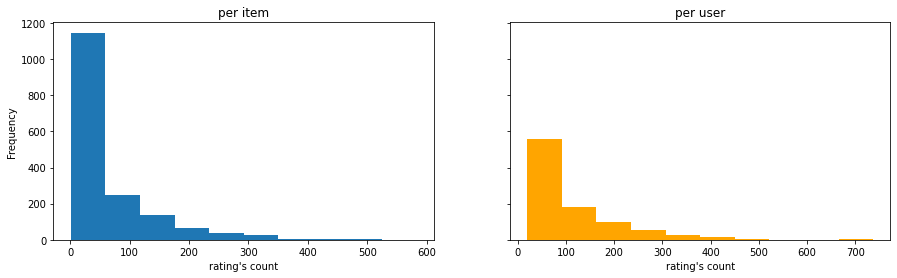

In [ ]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15, 4))

ratings.astype(bool).sum(axis=0).plot.hist(ax=ax[0])
ratings.astype(bool).sum(axis=1).plot.hist(ax=ax[1],color='orange')
ax[0].set_title('per item')
ax[1].set_title('per user')
ax[0].set_xlabel('rating\'s count')
ax[1].set_xlabel('rating\'s count');

**Distribution of average rating value  per user\item**

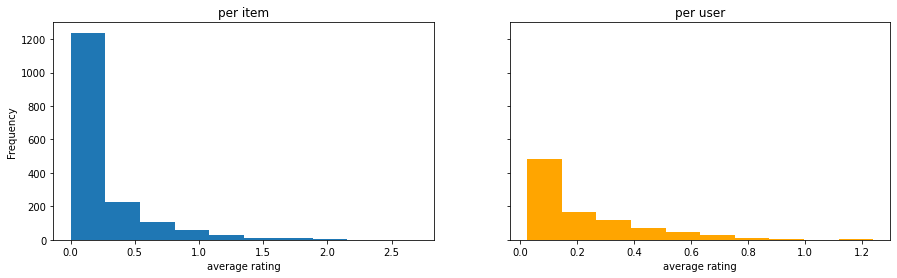

In [ ]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15, 4))

ratings.mean(axis=0).plot.hist(ax=ax[0])
ratings.mean(axis=1).plot.hist(ax=ax[1],color='orange')
ax[0].set_title('per item')
ax[1].set_title('per user')
ax[0].set_xlabel('average rating')
ax[1].set_xlabel('average rating');

**Movie ratings aggregated by user**

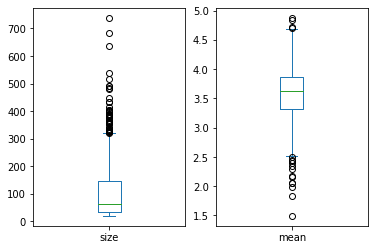

In [ ]:
userRatingsAggr = df_ratings.groupby(['user_id']).agg({'rating': [np.size, np.mean]})
userRatingsAggr.reset_index(inplace=True)  # To reset multilevel (pivot-like) index
userRatingsAggr['rating'].plot(kind='box', subplots=True)
plt.show();

**Genres**

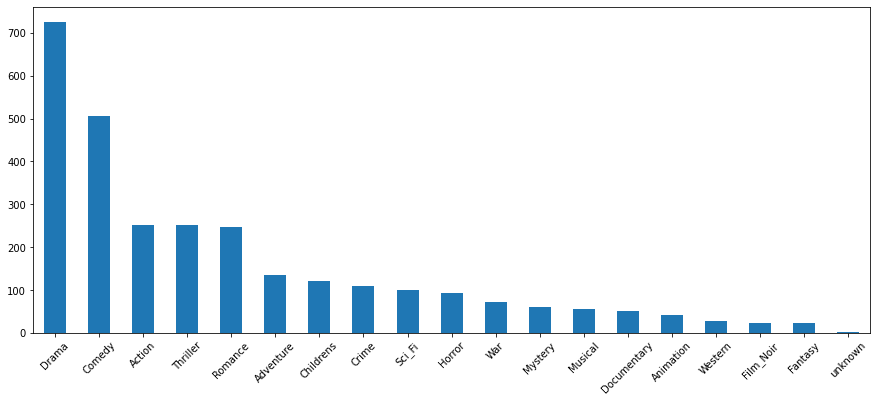

In [ ]:
plt.figure(figsize=(15,6))
df_items.iloc[:,5:].sum().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=45)
plt.show();

**Calculate the dataset sparsity:**

$$
Density  = \frac{\text{number of nonzero ratings in the matrix}}{\text{number of users}\times\text{number of items}} 
\quad \qquad
Sparsity = 1 - \frac{\text{number of nonzero ratings in the matrix}}{\text{number of users}\times\text{number of items}}
$$

In [ ]:
matrix_sparsity =  round((1-np.count_nonzero(ratings)/ratings.size)*100,2)
print('Sparsity is equal to {}%'.format(str(matrix_sparsity)) )

Sparsity is equal to 93.7%


<br><br><br><br><br><br>

# Question 2:


## Evaluation Metrics

Please create a class to calculate the following metrics on two different dataset (df_true,df_pred):
- RMSE
- MRR
- nDCG

**Notes:**
- Please read this great blog post: 
<a href='https://medium.com/swlh/rank-aware-recsys-evaluation-metrics-5191bba16832'>MRR vs MAP vs NDCG: Rank-Aware Evaluation Metrics And When To Use Them </a>
- Please consider edge cases - NaN, Null, Zeros, out of bound, eval time, etc.
- You can work with Dataframe or with Numpy arrays(matrix)
- You may remove/add params to these functions
- Please use only pytonic code!

In [ ]:
class my_metrics():
        
    def RMSE(df_true,df_pred,lower_bound=1,upper_bound=5):
        pass
    
    
    
    def MRR(df_true,df_pred,lower_bound=1,upper_bound=5,top_n=5):
        # please use MRR_for_user
        pass
    
    def MRR_for_user(user_true,user_pred,lower_bound=1,upper_bound=5,top_n=5):
        pass
    

    
    def NDCG(df_true,df_pred,lower_bound=1,upper_bound=5,top_n=5):
        # please use NDCG_for_user
        pass
        
    def NDCG_for_user(user_true,user_pred,lower_bound=1,upper_bound=5,top_n=5):
        # please use DCG function
        pass
    
    def DCG(rel,n):
        # please implement the DCG formula
        pass
    

    
    def get_error(df_true,df_pred):        
        return {'RMSE':my_metrics.RMSE(df_true,df_pred,),'MRR_5':my_metrics.MRR(df_true,df_pred,top_n=5),'MRR_10':my_metrics.MRR(df_true,df_pred,top_n=10),'NDCG_5':my_metrics.NDCG(df_true,df_pred,top_n=5),'NDCG_10':my_metrics.NDCG(df_true,df_pred,top_n=10)}


Checking your evaltuation metrics and performence:

In [ ]:
%time my_metrics.get_error(ratings,ratings)

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 9.06 µs


{'RMSE': None, 'MRR_5': None, 'MRR_10': None, 'NDCG_5': None, 'NDCG_10': None}

<br><br><br><br>

# Question 3

### Models Implementation & Evaluation
Split the data to train and test.  
Implement explicit matrix factorization algorithm to predict the rating a user will provide to an item and recommendation of top N items.   

Use the RMSE, MRR and NDCG metrics (based on Q2 implementation) to evaluate your recommender system. For the MRR and NDCG metrics use cutoff value of 5. Items with a rating of 3 and above are considered as relevant.   

Produce a learning curve graph and a table which compares the results of the following algorithms: 
 - Bias only based model
 - Simple popularity based model
 - Different choices of the latent factor dimension regularization, learning rate. 



**Save final results**

In [ ]:
final_results = pd.DataFrame(columns=['Method','Time','RMSE','MRR_5','MRR_10','NDCG_5','NDCG_10'])

**Choose fold**

In [ ]:
df_folds = {i:
       {'train' : pd.read_csv('{}u{}.base'.format(data_dir,i), delimiter='\t', header=None, names=cols_data),
        'test'  : pd.read_csv('{}u{}.test'.format(data_dir,i), delimiter='\t', header=None, names=cols_data)
       } for i in range(1,6)} 

def fold2df(i):
    train = df_folds[i]['train'].pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
    test  = df_folds[i]['test'].pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
    return train,test 

def getfulldf(train_fold,test_fold):
    train = ratings.copy()
    train[:] = 0
    test = train.copy()
    
    train.loc[train_fold.index,train_fold.columns] = train_fold.values
    test.loc[test_fold.index,test_fold.columns] = test_fold.values
    return train,test

fold = 1
train,test = getfulldf(*fold2df(1))

train.shape,test.shape

### A. Popularity model

Recommend the most popular movies which have more than 10 ratings.

Use the RMSE, MRR and NDCG metrics to evaluate your recommender system.   
For the MRR and NDCG metrics use cutoff values of 5 and 10.   

In [ ]:
class POP():

    def __init__(self,df_train,M=10):
    # df is the set to train on
    # N is the number of movies to recommend
    # M is the minimum votes required to be listed in the chart
        self.df_train = df_train
        self.min_movie_ratings = M
        self.recommended = ratings.copy()
        self.recommended[:] = 0
        self.fit_time = 0

        
    def fit(self):
        # please record the training time in fit_time
        pass
        
        
    def predict(self,N=10):
        pass
        
        
    def get_rmse(self,test):
        # please use my_metrics
        pass

    
    def get_mrr(self,test,k=10,threshold=3):
        # Please use my_metrics
        pass
    
    
    def get_ndcg(self,test,k=5):
        # please use my_metrics
        pass

    
    # this is just a quick checking function for you to use while debugging
    def predict_title(self):
        return df_items.set_index('movie id').loc[self.predict()]['movie_title']

Checking your model and performance:

In [ ]:
# create popularity model
model_pop = POP(train)

# train model
%timeit model_pop.fit()

# record model results
final_results.loc[len(final_results)] = 'Popularity', model_pop.fit_time, model_pop.get_rmse(test), model_pop.get_mrr(test,k=5), model_pop.get_mrr(test,k=10), model_pop.get_ndcg(test,k=5), model_pop.get_ndcg(test,k=10)

# display
final_results

### B. Explicit Matrix Factorization

**Implement explicit matrix factorization algorithm to predict the rating a user will provide to an item and recommendation of top N items.**

Use the RMSE, MRR and NDCG metrics to evaluate your recommender system.   
For the MRR and NDCG metrics use cutoff values of 5 and 10.   

In [ ]:
class MF():
    
    def __init__(self,df_train,n_factors=10,only_bias=False):
        self.df_train = df_train
        self.n_factors = n_factors
        self.only_bias = only_bias
        
        # rows==users , cols==items
        self.n_rows, self.n_cols = df_train.shape
        
        # biases
        self.original_bias_global = np.sum(df_train)/np.count_nonzero(df_train)
        self.original_bias_rows   = np.sum(df_train,axis=1)/np.count_nonzero(df_train,axis=1) 
        self.original_bias_cols   = np.sum(df_train,axis=0)/np.count_nonzero(df_train,axis=0)
        
        # "reset" initialization 
        self.initilize_params()
        
        
    def initilize_params(self):
        if self.only_bias:
            pass
        else:
            pass
        
        # initilize bias
        self.bias_global = self.original_bias_global   # no need to learn it
        self.bias_rows   = None # random
        self.bias_cols   = None # random
            
        
    def fit(self,
            n_iterations=1,
            learning_rate=1e-1,
            regularization=1e-2,
            convergence=1e-5,
            error='RMSE',
            initilize_training=True,
            verbose=True):
        
        self.n_iterations = n_iterations
        self.α = learning_rate
        self.λ = regularization
        self.ϵ = convergence
        self.error = error
                  
        if initilize_training:
            self.initilize_params()

           
        # please record your progress in history
        self.history = []
                  
        # please record the training time in fit_time
        self.fit_time = None

        # please use the class functions 
        # for example(!) :
        for current_iteration in range(self.n_iterations):
            
            # None ?
            self.history.append(self.get_rmse(None))
            
            # printing
            if verbose:
                print('iteration: ',current_iteration,' total error:\n',self.history[-1])
            
            # convergence
            if current_iteration!=0 and self.converging():
                
                if verbose:
                    print('converged...')
                break
            
            self.rows_indices = np.arange(self.n_rows)
            self.cols_indices = np.arange(self.n_cols)
            self.optim_GD()

    
    def converging(self):
        pass

                  
    def optim_GD(self):
        # you can use np.dot,np.eye,np.linalg.solve,etc.
        pass       
                
                  
    def step_rows(self):
        # make sure the signs are exacly as formula, For example:  YtY,λI,etc.
        pass
    
                  
    def step_cols(self):
        pass
    
        
    def predict(self,N=10):
        pass
        
        
    def get_rmse(self,test):
        # please use my_metrics
        pass

    
    def get_mrr(self,test,k=10,threshold=3):
        # Please use my_metrics
        pass
    
    
    def get_ndcg(self,test,k=5):
        # please use my_metrics
        pass

Checking your model and performance:

In [ ]:
# create MF model
model_mf = MF(train.values,n_factors=5,only_bias=False)

# train model
%time model_mf.fit(n_iterations=2,verbose=False,regularization=0.01,convergence=1e-100,learning_rate=0.1)

# record model results
final_results.loc[len(final_results)] = 'MF', model_mf.fit_time, model_mf.get_rmse(test), model_mf.get_mrr(test,k=5), model_mf.get_mrr(test,k=10), model_mf.get_ndcg(test,k=5), model_mf.get_ndcg(test,k=10)

# display
final_results

<br><br><br>

## C. Train & HyperParams Search 


**Different choices of the latent factor dimension, regularization, learning rate.**

and Find best hyperparameters


While running of these permutations:

    - n_iterations   = [20]     
    - convergence    = [1e-5]    
    - latent_factors = [5,10,20]    
    - regularization = [0.01,0.1,1]    
    - learning_rate  = [0.001,0.01,0.1]    



In [ ]:
n_iterations   = [20] # just one value due to computational power
convergence    = [1e-5,1e-3]  
latent_factors = [5, 10, 20]
regularization = [0.01, 0.1, 1]
learning_rate  = [0.001, 0.01, 0.1]

results = pd.DataFrame(columns=['Latent_factors','Iterations','Learning_Rate','Regularization','Convergence','RMSE','MRR_5','MRR_10','NDCG_5','NDCG_10','History','Time'])

for n_iter in n_iterations:
    for lf in latent_factors:
        for lr in learning_rate:
            for reg in regularization:
                for conv in convergence:

                    dic = {'Iterations':n_iter,'Latent_factors':lf,'Learning_Rate':lr,'Regularization':reg,'Convergence':conv}

                    # initialize model
                    mf = MF(train.values,n_factors=lf)
                    
                    # record training time
                    start = time.time()
                    
                    # train MF
                    mf.fit(verbose=False)
                    # mf.train(n_iterations=n_iter,verbose=False,optim='GD',learning_rate=lr,regularization=reg,convergence=conv)
                    
                    # record traning time
                    dic['Time'] = time.time() - start
                    
                    # eval model
                    # please use the model evaluation funcntions 
                    pass
                
                    # record model history
                    dic['History'] = [] # model 
                    
                    # add experiment
                    results = results.append(dic,ignore_index=True)

results

**Training history:**

In [ ]:
lines = results.History

plt.figure(figsize=(16,6))

for l in lines:
    plt.plot(l)

plt.xticks(np.arange(n_iterations[0]+1))
plt.legend(lines.index,loc='upper right',bbox_to_anchor=(1.1, 1.1))
plt.title('Training GD - RMSE History')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.show();

**Focus on the top 3:**

In [ ]:
results.loc[results.RMSE.nsmallest(3).index,:]

In [ ]:
lines = lines[results.RMSE.nsmallest(3).index]
plt.figure(figsize=(12,5))

for l in lines:
    plt.plot(l)

plt.xticks(np.arange(n_iterations[0]+1))

leg = (results.loc[results.RMSE.nsmallest(3).index,['Latent_factors','Learning_Rate','Regularization']]).T.to_dict().values()
plt.xticks(np.arange(n_iterations[0]+1))
plt.title('Training GD TOP3 - RMSE History')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.legend(leg)
plt.show();


**Q: is there a clear winner?**  

In [ ]:
# <answer here>

Please add your winner to `final_results` dataframe.

In [ ]:
final_results = pd.DataFrame(columns=final_results.columns)

pass

**Understanding The Effect - `Latent Factors` - Your Conclusions:**

In [ ]:
# <answer here>

**Understanding The Effect - `Learning Rate` - Your Conclusions:**


In [ ]:
# <answer here>

**Understanding The Effect - `Regularization` - Your Conclusions:**

In [ ]:
# <answer here>

<br><br><br>

## D. Bias only based model
#### Repeat the explicit matrix factorization implementation for the bias only model. Please use the same visualizations.  

<br>

**Hyperparams search + train the model :**

**Choose your top3 models:**


**Add your winner to `final_resuls` dataframe:**

<br><br>
**Different Methos - Conclude Final Results**

In [ ]:
final_results = final_results.set_index('Method')
final_results['Time_Ratio'] = final_results['Time_Ratio']/final_results['Time_Ratio'].max()

final_results.T.plot(kind="bar", figsize=(15,6))
plt.title("Results of all Methods", fontsize=20)
plt.xlabel("Evaluation Methods", fontsize=16)
plt.ylabel("Evaluation Values", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.show();

final_results

**Understand `only-Bias-model` VS `full-model` - Your Conclusions:**  
- 
-
-




<br><br><br><br><br><br><br>

## E. Discussion 

Describe your challenges and findings, including comparison between the algorithms as well as your recommendations for how to select the latent factor dimension, the contribution of regularization and pros\cons of the different algorithms.

In your comparison refer to the evaluation metrics, training and inference duration, learning convergence and additional aspects you find relevant.

`popularity bias:` Please refers to system recommends the movies with the most interactions without any personalization

`item cold-start problem:` Please refers to when movies added to the catalogue have either none or very little interactions while recommender rely on the movie’s interactions to make recommendations

`scalability issue:` Please refers to lack of the ability to scale to much larger sets of data when more and more users and movies added into our database

<< Your Answer here >> 

`MRR VS nDCG`

**MRR**  
`Pros:`   
    -   
    -   

`Cons:`    
    -   
    -   

**NDCG**  
`Pros:`  
    -   
    -   

`Cons:`  
    -   
    -   

<br><br><br><br>

# Question 4: 


## Item similarity & explainability 
a)	Suggest a method to find similarity between items. Demonstrate the approach on a set of 5 item pairs of your choice based on item representation by your best matrix factorization model. Leverage the items side information available in the dataset to demonstrate the effectiveness of the suggested approach. 

b)	Select two latent dimensions of your matrix factorization model and try to estimate the latent ‘meaning’ of the learnt matrix factorization model. Demonstrate your estimation, using few items from the dataset and the items side information available in the dataset and\or external information. 


**Find similarity between items and demonstrate the approach on a set of 3 item triplets of your choice based on item representation by your one of your top3 matrix factorization model.**
  
**Leverage the items side information available in the dataset to demonstrate the effectiveness of the suggested approach.**

In [ ]:
model = None
model.fit()

**Known methods to find similarity between items are:**
- Pearson Corellation  
- Cosine Similarity 
- Mean Difference
- L2 Distance

**Please implement them using numpy package:** 
(for example: np.linalg)


In [ ]:
def get_item2vec(mf,i):
    pass


def get_pearson_similarity(a,b):
    pass


def get_cosine_similarity(a,b):
    pass


def get_mean_diff_similarity(a1,a2):
    pass


def get_l2_similarity(a1,a2):
    pass


**For the next step, please choose your favorite method.**  

**Please compare 3 triplets of movies, and for each triplet create this:**   
Create a dataframe same as the example

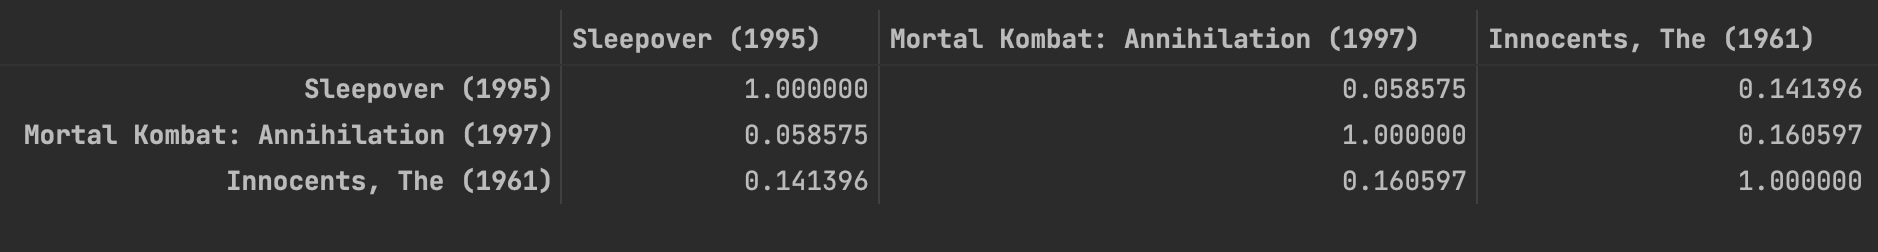

**First Triplet:**

**Second Triplet:**

**Third Triplet**

<br><br><br>
**Find two latent dimensions of your matrix factorization model and try to estimate the latent ‘meaning’ of the learnt matrix factorization model.**

**Tip:**  
would we get a good seperation for different genres?  
For example, here we can see that this is not a good seperation.




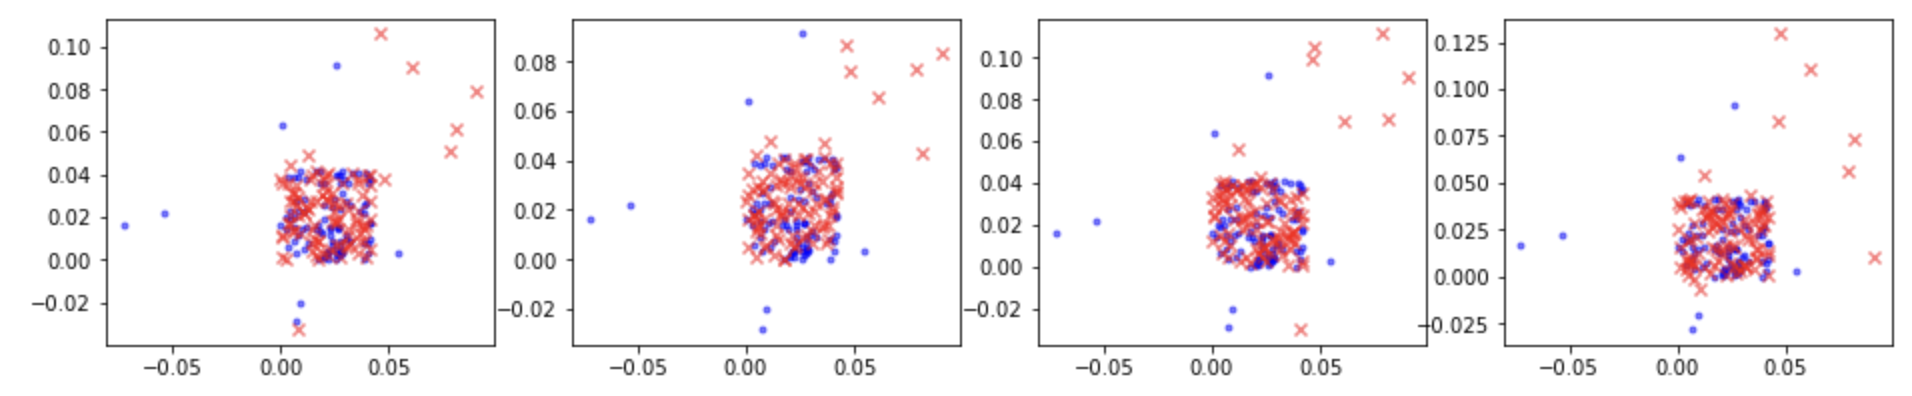